# Klasyfikacja wieloklasowa

W tym zadaniu zajmiemy się problem klasyfikacji wieloklasowej. Nadal będziemy pracować na danych dotyczących rodzajów fonacji - tym razem pięciu, odpowiednio z etykietami klas:

0. neutral - z nastawieniem miękkim;
1. pressed - z nastawieniem twardym, typ I;
2. pressedta - z nastawieniem twardym, typ II (wg autorów bazy "while pressed vocalization was achieved by raising the larynx, pressedta was an attempt to raise the subglottal pressure directly, without raising the larynx");
3. breathy - z nastawieniem chuchającym;
4. flow - "phonation type produced with the largest peak-to-peak flow amplitude, where the minimum still reaches zero" (miękkie nastawienie, głośniejszy, „podparty” dźwięk).

W macierzy zawierającej cechy ponownie mamy 13 MFCC i ich I i II pochodną, wyznaczone dla 909 sygnałów.

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, StratifiedKFold
from optuna import create_study
import os

In [8]:
# !unzip Lab6-zad2.zip
#wczytywanie danych
X = np.load(os.path.join('Lab6-zad2','all_padded_features_bin.npy')) # macierz cech - jednej wiersz = jeden obiekt
y = np.load(os.path.join('Lab6-zad2','all_labels_bin.npy')) # etykiety

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
SVM = SVC(C=1.0, random_state=42, kernel='linear')
SVM.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Klasyfikację wykonuje się tak samo bez względu na to, ile klas jest w zbiorze. Należy użyć metody `fit()` na zbiorze uczącym, a następnie `predict()` na zbiorze testowym.

## Wyznaczanie metryk

Różnica jest w obliczaniu metryk - większość z nich wymaga określenia, która klasa jest pozytywna, a która negatywna. Gdy mamy więcej niż 2 klasy, metryki wylicza się uśredniając wyniki uzyskane dla każdej z klas (zazwyczaj przy założeniu, że jest aktualnie rozpatrywana klasa jest pozytywna, a pozostałe negatywne). Trzeba określić, w jaki sposób będzie wyliczana średnia. Do wyboru mamy:

- weighted - średnia ważona, najlepsza, gdy mamy nierównoliczne klasy;
- macro - średnia arytmetyczna;
- micro  - wynik wyznaczony globalnie poprzez zliczenie wszystkich TP, FP i FN (od razu dla całych danych, a nie dla każdej klasy z osobna).

Policzmy, ile mamy obiektów w każdej z klas w zbiorze testowym, żeby wybrać sposób uśredniania przy liczeniu metryk.

<BarContainer object of 5 artists>

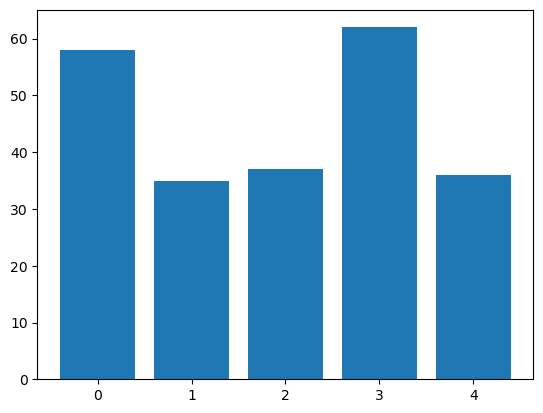

In [11]:
counter_ytest = np.unique(y_test, return_counts=True)
plt.bar(counter_ytest[0].astype(int), counter_ytest[1])

Jak widać, klasy nie są równoliczne, np. klasy 3 jest prawie 2x więcej niż klasy 1. Dlatego użyjemy średniej ważonej.

test accuracy =  0.868421052631579
test F1 =  0.866411699937264


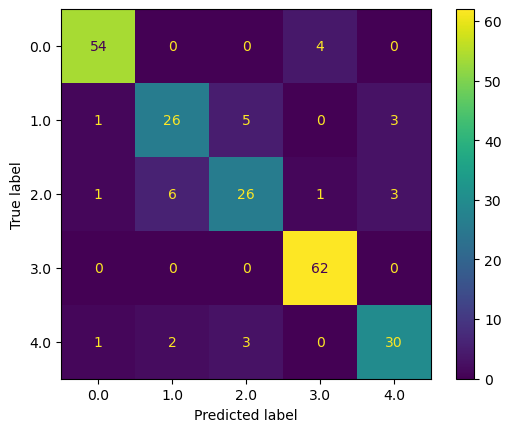

In [12]:
SVM_test_preds = SVM.predict(X_test)
print('test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, SVM_test_preds)

## Macierz pomyłek

Macierz pomyłek jest dużo bardziej rozbudowana niż w przypadku klasyfikacji binarnej. Da się z niej odczytać nie tylko, które obiekty zostały zaklasyfikowane poprawnie (wartości na przekątnej), ale też sprawdzić, do której konkretnie klasy zostały przyporządkowane te, które zaklasyfikowano nieprawidłowo.

Podobnie wyznaczanie krzywej ROC jest bardziej skomplikowane - można porównywać po kolei przyporządkowanie do klas parami (*one-vs-one*) lub dla każdej klasy sprawdzać klasyfikację w stosunku do wszystkich pozostałych (*one-vs-all*).

# Zadanie A

To była klasyfikacja na danych niestandaryzowanych. Przeprowadź teraz standaryzację i klasyfikację na danych standaryzowanych (możesz utworzyć w tym celu pipeline).

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVM.fit(X_train_scaled, y_train)
SVM_test_preds = SVM.predict(X_test_scaled)

print('scaled test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('scaled test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))

scaled test accuracy =  0.8070175438596491
scaled test F1 =  0.8030446434084204


# Zadanie B

Żeby spróbować jeszcze bardziej poprawić wyniki, poszukaj lepszych parametrów za pomocą optymalizacji lub wspomnianej w zad. 1 metody [*grid search*](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). Jedyna różnica - w przypadku modeli regresyjnych i klasyfikatorów binarnych funkcją celu może być ROC AUC, natomiast w przypadku większej liczby klas trzeba wybrać inną metrykę. Najczęściej jest to czułość (*accuracy*) lub F1. Zacznijmy od F1, które teoretycznie jest lepszą metryką, bo zawiera w sobie precyzję i czułość.

In [14]:
scoring = {'f1_macro': make_scorer(f1_score, average='weighted')}

Zdefiniuj siatkę parametrów i przeprowadź poszukiwanie najlepszego ich zestawu.

In [15]:
def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y,
                            scoring=scoring,
                            cv=StratifiedKFold(n_splits=5),
                            return_train_score=True)

    return np.mean(scores['test_f1_macro'])

def get_space(trial): 
    space = {"C": trial.suggest_float("C", 0, 1.5), 
           'max_iter': trial.suggest_int('max_iter', 100, 100),
           "kernel": trial.suggest_categorical("kernel", ["rbf", "linear", "poly"])}
    return space

In [18]:
model = SVC 
trials = 5

study = create_study(direction='maximize', study_name='multiclass_SVM_optimization')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2025-11-17 11:06:14,840] A new study created in memory with name: multiclass_SVM_optimization
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/pum/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnin

Dla modelu o wyznaczonych parametrach przeprowadź predykcję, oblicz dokładność, F1 i wyznacz macierz pomyłek.

In [ ]:
# trenowanie modelu o najlepszych hiperparametrach

# Zadanie C

Powtórz proces optymalizacji dla funkcji celu zdefiniowanej przez dokładność. Która dała lepsze wyniki? Jak bardzo udało się poprawić wyniki w porównaniu do nieoptymalizowanego modelu?

In [ ]:
scoring = {'acc_macro': make_scorer(accuracy_score, average='weighted')}